In [10]:

%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import os
import os.path as osp
from datasets import (
    load_eye,
)
import tqdm
import numpy as np

import pickle as pkl



In [4]:
from cluster import (
    normalize,
    cluster,
    compute_cost
)

In [7]:
from config import eye_config
print(eye_config)
args = eye_config



{'task_type': 'cluster', 'num_classes': 4, 'num_iters': 1000, 'output_dir': 'cluster_outputs'}


In [13]:
os.makedirs(args.output_dir, exist_ok=True)
data = load_eye()['train']
features, classes = data[:, :-1].astype(np.float32), data[..., -1].astype(np.int8)
num_samples, num_features = features.shape
features = normalize(features) # normalize except for the classes 

old_centers = np.random.randn(args.num_classes, num_features)
# old_centers = features[[0, 1, -1, -2]]
kmean_costs, kmedian_costs, kcenter_costs = [], [], []
tbar = tqdm.trange(args.num_iters)
for i in tbar:
    centers, assignment = cluster(features, old_centers)
    kmean_cost, kmedian_cost, kcenter_cost = compute_cost(features, old_centers, assignment)
    kmean_costs.append(kmean_cost)
    kmedian_costs.append(kmedian_cost)
    kcenter_costs.append(kcenter_cost)
    tbar.set_description_str(
        f'kmean_cost:{kmean_cost}; '
        f'kmedian_cost:{kmedian_cost}; '
        f'kcenter_cost:{kcenter_cost}; '
    )

    if np.all(np.isclose(old_centers, centers)):
        print('nearly no update in centers, will break')
        break
    else:
        old_centers = centers

losses = {
    'kmean_costs': kmean_costs,
    'kmedian_costs': kmedian_costs,
    'kcenter_costs': kcenter_costs,
}
with open(osp.join(args.output_dir, 'losses.pkl'), 'wb') as f:
    pkl.dump(losses, f)


  0%|          | 0/1000 [00:00<?, ?it/s]

kmean_cost:29.994021459724003; kmedian_cost:419.2634241265198; kcenter_cost:3.469555286879801; :   0%|          | 2/1000 [00:00<00:11, 84.59it/s]

nearly no update in centers, will break


In [14]:
losses


{'kmean_costs': [328914.62623384024, 105204.96151107352, 29.994021459724003],
 'kmedian_costs': [43615.88917138679, 945.5690911117123, 419.2634241265198],
 'kcenter_costs': [313.56115001789163, 3.474260850070722, 3.469555286879801]}

No handles with labels found to put in legend.


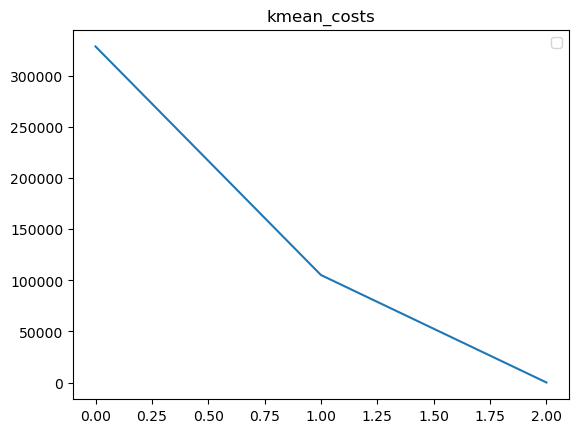

No handles with labels found to put in legend.


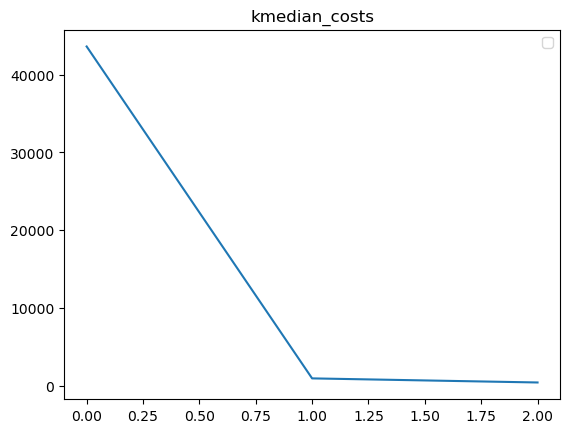

No handles with labels found to put in legend.


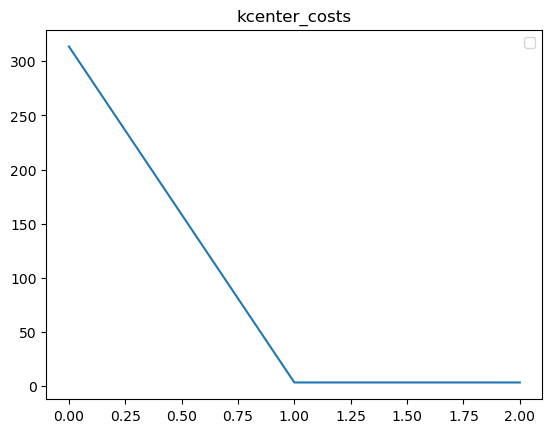

In [15]:
for costname, cost in losses.items():
    plt.plot(cost)
    plt.title(costname)
    plt.legend()
    plt.show()